In [1]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import spacy
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
spacy_eng = spacy.load("en_core_web_sm")
device

'cuda'

In [23]:
class Vocabulary():
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.stoi = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
        self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}

    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(sentence):
        return [token.text.lower() for token in spacy_eng.tokenizer(sentence)]
        
    def build_vocabulary(self, captions):
        word_occurence = {}
        index = 4

        for caption in captions:
            for word in self.tokenizer_eng(caption):
                if word not in word_occurence:
                    word_occurence[word] = 1
                else:
                    word_occurence[word] += 1
                if word_occurence[word] == self.freq_threshold:
                    self.stoi[word] = index
                    self.itos[index] = word
                    index += 1
            
    def numericalize(self, caption):
        tokenized_text = self.tokenizer_eng(caption)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [24]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, csv_file_path, transform = None, freq_threshold = 5):
        self.root_dir = root_dir
        self.transform = transform
        self.csv_data = pd.read_csv(csv_file_path)
        self.img_paths = self.csv_data["image"]
        self.captions = self.csv_data["caption"]

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        caption = self.captions[index]
        image = Image.open(os.path.join(self.root_dir, img_path)).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return image, torch.tensor(numericalized_caption)

In [25]:
class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    
    def __call__(self, batch):
        images = [item[0].unsqueeze(0) for item in batch]
        images = torch.cat(images, dim = 0)
        captions = [item[1] for item in batch]
        captions = pad_sequence(captions, batch_first = False, padding_value = self.pad_idx)

        return images, captions

In [26]:
def get_loader(
        root_dir, 
        csv_file_path,
        transform,
        batch_size = 32,
        num_workers = 8,
        shuffle = True,
        pin_memory = True,
):
    
    dataset = CustomDataset(root_dir, csv_file_path, transform)
    pad_idx = dataset.vocab.stoi["<PAD>"]
    dataloader = DataLoader(dataset = dataset,
                            shuffle = shuffle,
                        #     num_workers = num_workers,
                            pin_memory = pin_memory,
                            batch_size = batch_size,
                            collate_fn = Collate(pad_idx)
                            )

    return dataset, dataloader

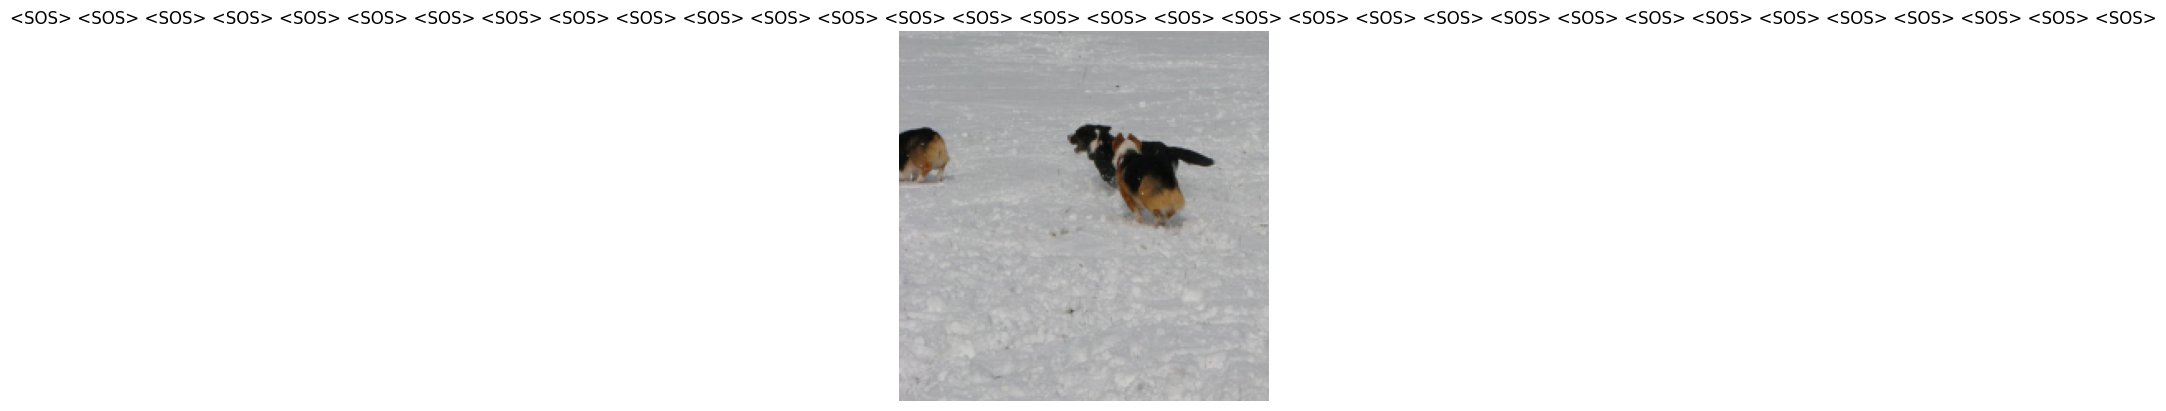

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
['<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>']


In [27]:
# if __name__ == "__main__":
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

root_dir = "captioning-dataset/flickr8k/images"
csv_file_path = "captioning-dataset/flickr8k/captions.txt"
dataset, dataloader = get_loader(root_dir, csv_file_path, transform)

image_batch = next(iter(dataloader))[0]
caption_batch = next(iter(dataloader))[1]
image = image_batch[0]
image = image.permute(1, 2, 0).detach().cpu()
caption = caption_batch[0]
plt.imshow(image)
caption_str = " ".join([dataset.vocab.itos[token.item()] for token in caption])
plt.title(caption_str)
plt.axis("off")
plt.show()

print(caption)
print([dataset.vocab.itos[token.item()] for token in caption])
